**Домашнее задание Ultra Pro: обработка текстов с помощью нейросетей**

На этот раз задача усложняется: нужно распознать 20 русских писателей, а не 6, как раньше. Для этого потребуется более объёмная база данных для обучения. Ячейка для скачивания базы данных уже есть в ноутбуке с заданием.

**Задание состоит из нескольких этапов:**
1. Скачайте базу данных по предоставленной ссылке и подготовьте файлы базы для обработки.
2. Создайте обучающую и проверочную выборки, уделяя особое внимание балансировке базы: количество примеров каждого класса должно быть примерно одинаковым. Используйте цикл для разбивки данных. Проверочная выборка должна составлять 20% от общей выборки.
3. Подготовьте данные для обучения и обучите сеть. Добейтесь точности сети не менее 95% на проверочной выборке модели Bag of Words и 75–80% — для модели Embedding. Каждый пункт задания важен


## Загрузка данных и подготовка данных для обработки

**Подключение библиотек**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gdown
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
gdown.download('https://drive.google.com/uc?id=1mRfaDmJYeYKUlqoNioOalZZngt5ZvKUE')

Downloading...
From (original): https://drive.google.com/uc?id=1mRfaDmJYeYKUlqoNioOalZZngt5ZvKUE
From (redirected): https://drive.google.com/uc?id=1mRfaDmJYeYKUlqoNioOalZZngt5ZvKUE&confirm=t&uuid=e5aa2400-fb37-4dd8-904a-1ac8c73daa4a
To: /content/20writers.zip
100%|██████████| 28.5M/28.5M [00:00<00:00, 37.2MB/s]


'20writers.zip'

In [ ]:
!unzip -qo 20writers.zip -d writers/
!ls writers

Беляев.txt    Гончаров.txt     Каверин.txt    Лесков.txt     Толстой.txt
Булгаков.txt  Горький.txt      Катаев.txt     Носов.txt      Тургенев.txt
Васильев.txt  Грибоедов.txt    Куприн.txt     Пастернак.txt  Чехов.txt
Гоголь.txt    Достоевский.txt  Лермонтов.txt  Пушкин.txt     Шолохов.txt


In [ ]:
# Чтение файла в текст.Данный код читает все текстовые файлы
def text_read(path):               # функция принимает имя файла
    f = open(path, 'r')            # задаем открытие нужного файла в режиме чтения
    text = f.read()                # читаем текст
    text = text.replace('\n',' ')  # переносы строки переводим в пробелы
    return text                    # функция возвращает текст файла

In [ ]:
#Загружаем тексты
path = '/content/writers'
className = sorted(os.listdir(path)) # добавляет все файлы в один список
nClasses = len(className) #считаем кол-во классов

data_text = [] #загрузка текстов из файлов
for i in className:
    data_text.append(text_read(os.path.join(path,i)))

In [ ]:
total_chars = sum(len(text) for text in data_text)
print(total_chars) #всего символов в data_text

56208451


In [ ]:
char_counts = [len(text) for text in data_text]
print(char_counts)  #проверим кол-во символов в каждом тексте отдельно

[2255254, 2001064, 2952792, 1965119, 3104712, 2523380, 969109, 5178950, 1992830, 2579246, 2328900, 1972541, 2152214, 2399413, 3089426, 3408339, 3357061, 1980206, 6611627, 3386268]


In [ ]:
className

['Беляев.txt',
 'Булгаков.txt',
 'Васильев.txt',
 'Гоголь.txt',
 'Гончаров.txt',
 'Горький.txt',
 'Грибоедов.txt',
 'Достоевский.txt',
 'Каверин.txt',
 'Катаев.txt',
 'Куприн.txt',
 'Лермонтов.txt',
 'Лесков.txt',
 'Носов.txt',
 'Пастернак.txt',
 'Пушкин.txt',
 'Толстой.txt',
 'Тургенев.txt',
 'Чехов.txt',
 'Шолохов.txt']

In [ ]:
nClasses

20

###Cоздание обучающей и тестовой выборок

In [ ]:
# Разделяем на обучающую/проверочную выборки
num = 0.2 #выделяем в тестовую выборку 20%
train_text = [] #список для обучающей выборки
test_text = [] #список для тестовой выборки
for i in range(nClasses):
    train_text.append(data_text[i][:-int(len(data_text[i])*num)])
    test_text.append(data_text[i][-int(len(data_text[i])*num):])

Как работает код выше?
*   указываем что для тестовой выборки будем использовать 20% текста (каждого писателя)
*   создаем пустые списки для тестовой выборки и обучающей выборки

Например:

*   data_text = [
    "1234567890",  # 10 символов
    "abcdefghij",  # 10 символов
    "0123456789012345",  # 16 символов
    ...
]

*   После разбиения (num = 0.2):


train_text получит первые 80% символов:
train_text = [
    "12345678",  # 8 символов (80% от 10)
    "abcdefgh",  # 8 символов (80% от 10)
    "0123456789012",  # 12 символов (80% от 16)
    ...
]


*   test_text получит последние 20% символов:
test_text = [
    "90",  # 2 символа (20% от 10)
    "ij",  # 2 символа (20% от 10)
    "345",  # 3 символа (20% от 16)
    ...
]


В итоге:
*  train_text содержит 20 текстов (укороченные на 20%)
*  test_text содержит 20 текстов (взявшие последние 20%)
*  Каждый текст в train_text примерно в 4 раза длиннее, чем в test_text










** Код ниже превращает последовательность индексов слов (wordIndexes) в набор более коротких векторов фиксированной длины (xLen) с заданным шагом (step).**

In [ ]:
# Формирование обучающей выборки по листу индексов слов (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): #wordIndexes - список индексов слов, xLen-длина каждого получаемого вектора, step - шаг, с которым сдвигается окно при разбиении
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0

  # Идём по всей длине вектора индексов
  # "Откусываем" векторы длины xLen и смещаеммся вперёд на step

  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step

  return xSample

**Как происходить разбиение индексов?**
*   Берётся подсписок длины xLen из wordIndexes
*   Записывается в xSample
*   Сдвигаем index на step и повторяем
*   Когда не хватает символов для полного вектора (index + xLen > wordsLen), цикл прекращается.

Например:

xLen = 4
step = 2

result = getSetFromIndexes(wordIndexes, xLen, step)
print(result)

*   wordIndexes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
*   xLen = 4
*   step = 2
*   result = getSetFromIndexes(wordIndexes, xLen, step)


Выход этого кода:

[
    [1, 2, 3, 4],  
    [3, 4, 5, 6],  
    [5, 6, 7, 8],  
    [7, 8, 9, 10]
]



Здесь шаг 2, поэтому новые отрезки пересекаются

Теперь каждая строка — это один обучающий пример для сети.





**Зачем разбивать на короткие векторы?**
1.   Нейросеть принимает фиксированный размер входных данных
*   Тексты бывают разной длины, но модели (например, RNN, LSTM, CNN) требуют входные последовательности одинаковой длины (xLen)
*   Этот код превращает текст в подпоследовательности одинаковой длины.
2.   Увеличение обучающей выборки
*   Если просто передавать весь текст, у нас будет 1 пример на текст.
*   Разбивая текст на пересекающиеся фрагменты, мы создаём больше примеров, что помогает модели лучше учиться.
3. Учитывание контекста
*   Благодаря step создаются перекрывающиеся окна, позволяя модели видеть слова в разных контекстах.
*   Например, при анализе предложений сеть получает разные сочетания слов, а не только изолированные куски.







**Код ниже разбивает текстовые данные (в виде индексов слов) на фиксированные отрезки и формирует обучающую выборку (xSamples) и метки классов (ySamples).**

In [ ]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов

def createSetsMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов выборки
  classesXSamples = []        # здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна"
  for wI in wordIndexes:      # для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна"

  # Формируем один общий xSamples
  xSamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна(например 15779*1000)"
  ySamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 20"

  for t in range(nClasses):  # в диапазоне кол-ва классов
    xT = classesXSamples[t]  # берем очередной текст вида "кол-во окон в тексте*длину окна"(например 1341*1000)
    for i in range(len(xT)): # и каждое его окно
      xSamples.append(xT[i]) # добавляем в общий список выборки

    # Формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses) # текущий класс переводится в вектор длиной 20 вида [0.0.0.1.0.0.0.....]
    for i in range(len(xT)): # на каждое окно выборки
      ySamples.append(currY) # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # переводим в массив numpy для подачи в нейронку


  return (xSamples, ySamples)   # функция возвращает выборку и соответствующие векторы классов

Как работает код выше?

Пример на 3 классах текста:



In [ ]:
#Допустим, у нас есть 3 класса текстов:
#На вход:
wordIndexes = [
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],   # 1-й класс
    [11, 12, 13, 14, 15, 16, 17, 18],  # 2-й класс
    [19, 20, 21, 22, 23, 24, 25, 26]   # 3-й класс
]
#Вызываем функцию:
xSamples, ySamples = createSetsMultiClasses(wordIndexes, xLen=4, step=2)
#На выходе получаем xSamples:
[
    [1, 2, 3, 4],   # Из 1-го класса
    [3, 4, 5, 6],
    [5, 6, 7, 8],
    [7, 8, 9, 10],
    [11, 12, 13, 14],  # Из 2-го класса
    [13, 14, 15, 16],
    [15, 16, 17, 18],
    [19, 20, 21, 22],  # Из 3-го класса
    [21, 22, 23, 24],
    [23, 24, 25, 26]
]
# и ySamples:
[
    [1, 0, 0],  # 1-й класс
    [1, 0, 0],
    [1, 0, 0],
    [1, 0, 0],
    [0, 1, 0],  # 2-й класс
    [0, 1, 0],
    [0, 1, 0],
    [0, 0, 1],  # 3-й класс
    [0, 0, 1],
    [0, 0, 1]
]
#xSamples - обучающая выборка
#ySamples - правильные ответы к обучающей выборке (метки классов) Вектора OHE

**код ниже преобразует текстовые данные в числовые последовательности для подачи в нейросеть.**

In [ ]:
# Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
max_words_count = 5000 # определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=max_words_count, filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower=True, split=' ', char_level=False, oov_token = 'unknown')
# выше задаем параметры:
# (num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# (filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
# (lower=True) - приводим слова к нижнему регистру
# (split=' ') - разделяем слова по пробелу
# (char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(data_text) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) #вытаскиваем индексы слов для просмотра


xlen = 1000 # Длина отрезка текста, по которой анализируем, в словах
step = 200 # Шаг разбиения исходного текста на обучающие вектора

train_words_indexes = tokenizer.texts_to_sequences(train_text)
test_words_indexes = tokenizer.texts_to_sequences(test_text)
x_train, y_train = createSetsMultiClasses(train_words_indexes, xlen, step)
x_test, y_test = createSetsMultiClasses(test_words_indexes, xlen, step)

Что делает этот код?
*   Создаёт Tokenizer из Keras (Преобразует слова в индексы/словарь частотности,удаляет ненужные символы, приводит текст к нижнему регистру, ограничивает словарь 5000 самыми частыми словами)
*   Обучает Tokenizer на текстах(tokenizer.fit_on_texts(data_text) - создаёт словарь (слово → индекс).например {"кот": 1, "собака": 2, "бегает": 3})
*   Конвертирует тексты в индексы(texts_to_sequences() - ["кот бегает", "собака спит"] -[[1, 3], [2, 4]] (если "спит" = 4 в словаре))
*   Разбивает тексты на короткие последовательности (x_train, x_test)-(Использует createSetsMultiClasses,xlen = 1000: Каждое окно содержит 1000 слов, step = 200: Сдвигаем окно на 200 слов)





In [ ]:
#Например:
data_t = ["Кот бежал по крыше", "Собака лаяла на прохожих"]
#Токенайзер создает словарь:
{
    "кот": 1,
    "бежал": 2,
    "по": 3,
    "крыше": 4,
    "собака": 5,
    "лаяла": 6,
    "на": 7,
    "прохожих": 8
}
#Преобразуем тексты в индексы:
train_words_ind = tokenizer.texts_to_sequences(train_text)
# [["Кот бежал по крыше"], ["Собака лаяла на прохожих"]]
# Результат: [[1, 2, 3, 4], [5, 6, 7, 8]]

#Разбиваем на обучающие примеры:
x_train, y_train = createSetsMultiClasses(train_words_indexes, xlen=2, step=1)

#Получим разбитые последовательности по xlen=2:
x_train = [
    [1, 2],  # "Кот бежал"
    [2, 3],  # "бежал по"
    [3, 4],  # "по крыше"
    [5, 6],  # "Собака лаяла"
    [6, 7],  # "лаяла на"
    [7, 8]   # "на прохожих"
]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/x_train.npy', x_train)
np.save('/content/drive/MyDrive/Colab Notebooks/y_train.npy', y_train)
np.save('/content/drive/MyDrive/Colab Notebooks/x_test.npy', x_test)
np.save('/content/drive/MyDrive/Colab Notebooks/y_test.npy', y_test)

In [ ]:
x_train = np.load('/content/drive/MyDrive/Colab Notebooks/x_train.npy')
y_train = np.load('/content/drive/MyDrive/Colab Notebooks/y_train.npy')
x_test = np.load('/content/drive/MyDrive/Colab Notebooks/x_test.npy')
y_test = np.load('/content/drive/MyDrive/Colab Notebooks/y_test.npy')

**код ниже преобразует последовательности слов (индексы слов) в матрицу признаков для подачи в нейросеть.**

In [ ]:
x_train01 = tokenizer.sequences_to_matrix(x_train.tolist()) #Подаем xTrain в виде списка, чтобы метод успешно срабтал
x_test01 = tokenizer.sequences_to_matrix(x_test.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

##BoW

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8565 - loss: 0.5367 - val_accuracy: 0.9380 - val_loss: 0.2746
Epoch 2/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9941 - loss: 0.0178 - val_accuracy: 0.9414 - val_loss: 0.2446
Epoch 3/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9925 - loss: 0.0143 - val_accuracy: 0.9454 - val_loss: 0.2253
Epoch 4/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9932 - loss: 0.0150 - val_accuracy: 0.9446 - val_loss: 0.2312
Epoch 5/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9942 - loss: 0.0101 - val_accuracy: 0.9442 - val_loss: 0.2330
Epoch 6/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9940 - loss: 0.0101 - val_accuracy: 0.9482 - val_loss: 0.2153
Epoch 7/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9947 - loss: 0.0091 - val_accuracy: 0.9483 - val_loss: 0.2213
Epoch 8/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9938 - loss: 0.0101 - val_accuracy: 0

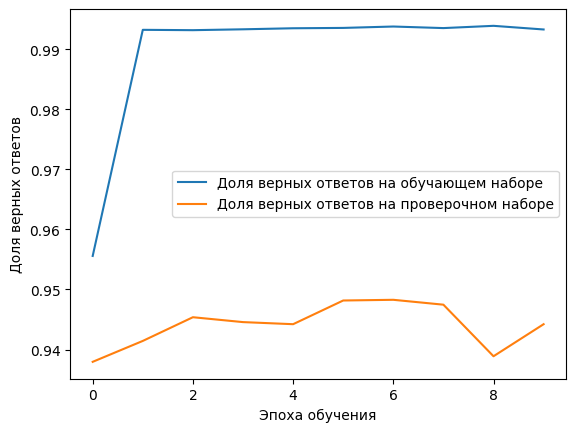

In [ ]:
model01 = Sequential()
model01.add(Dense(500, input_dim=max_words_count, activation="relu"))
model01.add(Dropout(0.25))
model01.add(BatchNormalization())
model01.add(Dense(20, activation='softmax'))
model01.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model01.fit(x_train01,
                      y_train,
                      epochs=10,
                      batch_size=128,
                      validation_data=(x_test01, y_test))

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Вывод:
*   Точность на обучающем наборе: Очень высокая, приближается к 100%.
*   Точность на валидации: Хорошая, но есть небольшие колебания (на последних эпохах точность немного снизилась).
*   Потери: Быстро снижаются и стабилизируются на низких значениях.





##Embedding

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.1992 - loss: 3.2155 - val_accuracy: 0.0424 - val_loss: 2.9915
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9685 - loss: 0.1899 - val_accuracy: 0.1236 - val_loss: 2.5486
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9942 - loss: 0.0534 - val_accuracy: 0.4890 - val_loss: 1.6620
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9951 - loss: 0.0336 - val_accuracy: 0.6643 - val_loss: 1.1206
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9973 - loss: 0.0204 - val_accuracy: 0.7153 - val_loss: 0.9476
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9978 - loss: 0.0154 - val_accuracy: 0.7006 - val_loss: 0.9938
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9983 - loss: 0.0129 - val_accuracy: 0.7127 - val_loss: 1.0143
Epoch 8/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9976 - loss: 0.0131 - val_acc

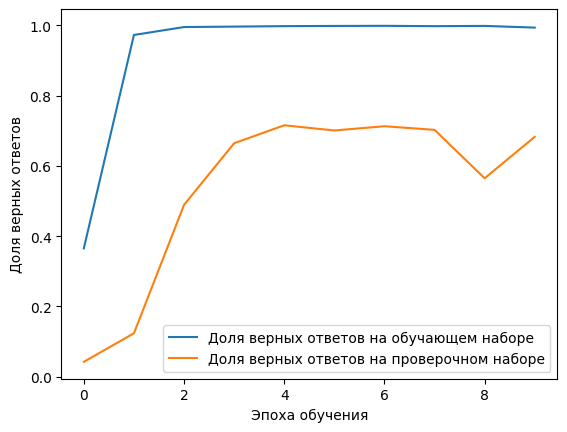

In [ ]:
model= Sequential()
model.add(Embedding(max_words_count , output_dim=20, input_length=xlen))
model.add(SpatialDropout1D(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(20, activation='softmax'))
model.compile(optimizer='adam', metrics=['accuracy'], loss = 'categorical_crossentropy')
history = model.fit(x_train, y_train, batch_size=256, epochs=10, validation_data=(x_test, y_test), verbose=1)
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Вывод:


*   Точность на обучающем наборе: Очень высокая, почти 100% к 10-й эпохе
*   Точность на валидации: Изначально наблюдается рост, но к 9-й эпохе происходит снижение. Возможно, это сигнализирует о переобучении.
*   Потери: Потери на обучении и валидации стабилизировались, но на валидации они увеличиваются


Для улучшения обучения на проверочной выборке попробуем:
*   использовать регуляризацию
*   SpatialDropOut
*   Early Stopping(в случае. если точность не улучшится)

##Дообучение модели Embedding

Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.2043 - loss: 12.3927 - val_accuracy: 0.0407 - val_loss: 7.0908
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9430 - loss: 3.2490 - val_accuracy: 0.2256 - val_loss: 5.1653
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9236 - loss: 2.8492 - val_accuracy: 0.5928 - val_loss: 3.6392
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9307 - loss: 2.8376 - val_accuracy: 0.6880 - val_loss: 3.0651
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9354 - loss: 2.8709 - val_accuracy: 0.7456 - val_loss: 3.0974
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9461 - loss: 2.5813 - val_accuracy: 0.7724 - val_loss: 3.0189
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9446 - loss: 2.7881 - val_accuracy: 0.7688 - val_loss: 2.9929
Epoch 8/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9231 - loss: 3.6199 - val_ac

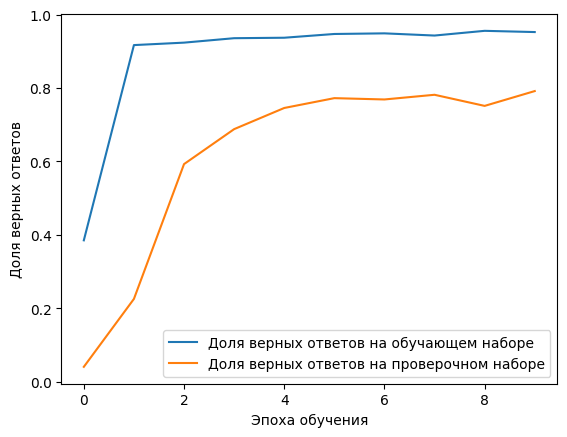

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Модифицированная модель с добавлением L2 регуляризации
model = Sequential()
model.add(Embedding(max_words_count, output_dim=20, input_length=xlen))
model.add(SpatialDropout1D(0.2))  # Применение SpatialDropout
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.01)))  # L2 регуляризация для предотвращения переобучения
model.add(Dropout(0.25))  # Dropout для предотвращения переобучения
model.add(BatchNormalization())
model.add(Dense(20, activation='softmax'))
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

# Ранняя остановка для предотвращения переобучения
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Обучение модели с добавлением ранней остановки
history = model.fit(
    x_train, y_train,
    batch_size=256,
    epochs=10,
    validation_data=(x_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

# Построение графика точности
plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Вывод: Результаты обучения показывают определённое улучшение по сравнению с предыдущими эпохами.